In [39]:
import pandas as pd
import numpy as np
from IPython.display import display

# Load
df = pd.read_csv("D598_Data_Set.csv")

# Sanity-check required columns 
required = ["Business ID", "Business State", "Total Revenue", "Profit Margin"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}\nAvailable: {list(df.columns)}")

# Medians (quadrant thresholds)
pm_med  = float(df["Profit Margin"].median())
rev_med = float(df["Total Revenue"].median())

# Flags & segment
df["PM_high"]  = df["Profit Margin"] >= pm_med
df["Rev_high"] = df["Total Revenue"] >= rev_med

def label(row):
    if row["Rev_high"] and row["PM_high"]:
        return "STARS"
    if row["Rev_high"] and not row["PM_high"]:
        return "VOLUME PLAYERS"
    if (not row["Rev_high"]) and row["PM_high"]:
        return "NICHE WINNERS"
    return "STRUGGLERS"

df["Segment"] = df.apply(label, axis=1)

# 2x2 matrix
matrix = pd.crosstab(
    index=df["Rev_high"].map({True:"High Revenue (≥ median)", False:"Low Revenue (< median)"}),
    columns=df["PM_high"].map({True:"High PM (≥ median)", False:"Low PM (< median)"})
).reindex(
    index=["High Revenue (≥ median)", "Low Revenue (< median)"],
    columns=["High PM (≥ median)", "Low PM (< median)"]
).fillna(0).astype(int)

# Segment summary
summary = (df.groupby("Segment", as_index=False)
             .agg(Count=("Business ID","count"),
                  Total_Revenue=("Total Revenue","sum"),
                  Avg_PM=("Profit Margin","mean"))
             .sort_values(["Segment"], key=lambda s: s.map({
                 "STARS":0, "VOLUME PLAYERS":1, "NICHE WINNERS":2, "STRUGGLERS":3
             })))

# Pretty medians table
med_info = pd.DataFrame({
    "Metric": ["Revenue median", "Profit Margin median"],
    "Value": [rev_med, pm_med]
})

# Show results
print("== Medians used ==")
display(med_info.style.format({"Value": "{:,.2f}"}))

print("\n== BCG Matrix: Counts by Quadrant ==")
display(matrix.style.set_properties(**{"text-align": "center"}))

print("\n== Segment summary ==")
display(summary.style.format({
    "Total_Revenue": "${:,.0f}",
    "Avg_PM": "{:.2%}"
}))

print("\n== Sample rows with assigned segment ==")
display(df[["Business ID","Business State","Total Revenue","Profit Margin","Segment"]].head(20).style.format({
    "Total Revenue": "${:,.0f}",
    "Profit Margin": "{:.2%}"
}))

== Medians used ==


,Metric,Value
0,Revenue median,"89,685,500.00"
1,Profit Margin median,0.27



== BCG Matrix: Counts by Quadrant ==


PM_high,High PM (≥ median),Low PM (< median)
Rev_high,,
High Revenue (≥ median),30,45
Low Revenue (< median),45,30



== Segment summary ==


,Segment,Count,Total_Revenue,Avg_PM
1,STARS,30,"$14,984,999,146",40.46%
3,VOLUME PLAYERS,45,"$33,420,192,066",13.75%
0,NICHE WINNERS,45,"$1,429,584,343",45.64%
2,STRUGGLERS,30,"$1,125,291,976",-408.47%



== Sample rows with assigned segment ==


,Business ID,Business State,Total Revenue,Profit Margin,Segment
0,41872013,Kentucky,"$136,753,000",2.37%,VOLUME PLAYERS
1,76232013,Iowa,"$34,226,553",26.50%,STRUGGLERS
2,160992013,Texas,"$384,196,000",13.04%,VOLUME PLAYERS
3,197452013,Delaware,"$444,306,000",19.68%,VOLUME PLAYERS
4,241042013,Illinois,"$121,541,000",16.83%,VOLUME PLAYERS
5,252122013,Massachusetts,"$270,950,000",30.81%,STARS
6,293322013,Tennessee,"$344,374,000",29.13%,STARS
7,303022013,Texas,"$481,788,000",28.76%,STARS
8,308312013,Massachusetts,"$42,753,000",46.04%,NICHE WINNERS
9,334882013,Indiana,"$132,991,000",16.45%,VOLUME PLAYERS


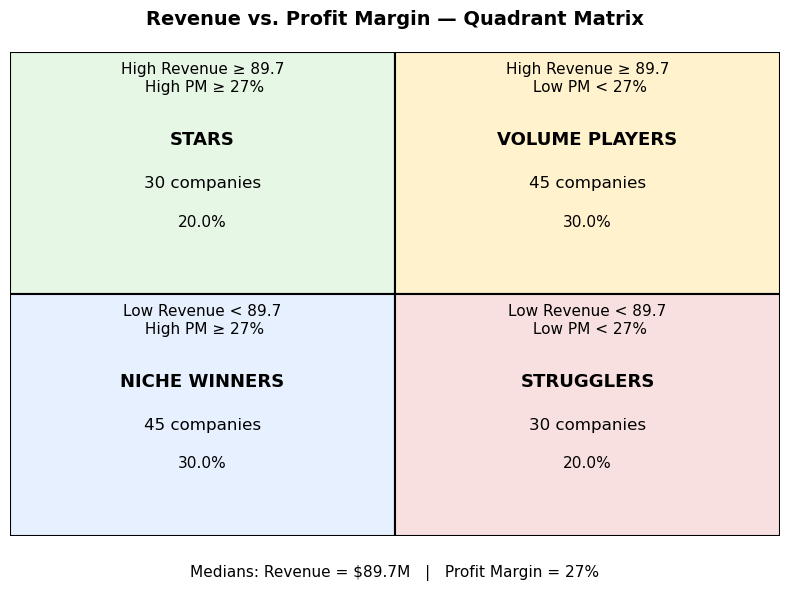

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Load
df = pd.read_csv("D598_Data_Set.csv")

# Medians (thresholds)
pm_med  = float(df["Profit Margin"].median())
rev_med = float(df["Total Revenue"].median())

# Flags & segments 
df["PM_high"]  = df["Profit Margin"] >= pm_med
df["Rev_high"] = df["Total Revenue"] >= rev_med

def segment_label(r_high, pm_high):
    if r_high and pm_high:   return "STARS"
    if r_high and not pm_high: return "VOLUME PLAYERS"
    if (not r_high) and pm_high: return "NICHE WINNERS"
    return "STRUGGLERS"

df["Segment"] = [segment_label(r,p) for r,p in zip(df["Rev_high"], df["PM_high"])]

# 2×2 
# rows: High Rev / Low Rev ; cols: High PM / Low PM
matrix = pd.crosstab(
    index=df["Rev_high"].map({True:"High Revenue (≥ median)", False:"Low Revenue (< median)"}),
    columns=df["PM_high"].map({True:"High PM (≥ median)", False:"Low PM (< median)"})
).reindex(index=["High Revenue (≥ median)", "Low Revenue (< median)"],
          columns=["High PM (≥ median)", "Low PM (< median)"]).fillna(0).astype(int)

# Extract counts by quadrant for convenience
stars        = int(matrix.loc["High Revenue (≥ median)", "High PM (≥ median)"])
volume       = int(matrix.loc["High Revenue (≥ median)", "Low PM (< median)"])
niche        = int(matrix.loc["Low Revenue (< median)", "High PM (≥ median)"])
strugglers   = int(matrix.loc["Low Revenue (< median)", "Low PM (< median)"])

total = stars + volume + niche + strugglers
pct = lambda n: f"{(n/total*100):.1f}%"

# Helper to format medians
def fmt_money_short(x):
    if x >= 1_000_000_000: return f"${x/1_000_000_000:.1f}B"
    if x >= 1_000_000:     return f"${x/1_000_000:.1f}M"
    if x >= 1_000:         return f"${x/1_000:.0f}K"
    return f"${x:.0f}"

# Draw the matrix
fig, ax = plt.subplots(figsize=(8, 6))

# Coordinate system: x in [0,1], y in [0,1]
ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.axis("off")

# Colors
c_stars      = "#E6F7E6"   # light green
c_volume     = "#FFF2CC"   # light yellow
c_niche      = "#E6F0FF"   # light blue
c_strugglers = "#F9E0E0"   # light red/pink
edge = dict(ec="black", lw=1.5)

# Rects: [x, y, width, height]
# Top row (High Revenue)
ax.add_patch(Rectangle((0.00, 0.50), 0.50, 0.50, fc=c_stars,      **edge))  # Stars (High Rev, High PM)
ax.add_patch(Rectangle((0.50, 0.50), 0.50, 0.50, fc=c_volume,     **edge))  # Volume Players (High Rev, Low PM)
# Bottom row (Low Revenue)
ax.add_patch(Rectangle((0.00, 0.00), 0.50, 0.50, fc=c_niche,      **edge))  # Niche Winners (Low Rev, High PM)
ax.add_patch(Rectangle((0.50, 0.00), 0.50, 0.50, fc=c_strugglers, **edge))  # Strugglers (Low Rev, Low PM)

# Labels inside each quadrant (title + count + percent)
def quad_text(xc, yc, title, count):
    ax.text(xc, yc+0.07, title, ha="center", va="center", fontsize=13, fontweight="bold")
    ax.text(xc, yc-0.02, f"{count:,} companies", ha="center", va="center", fontsize=12)
    ax.text(xc, yc-0.10, pct(count), ha="center", va="center", fontsize=11)

quad_text(0.25, 0.75, "STARS",          stars)
quad_text(0.75, 0.75, "VOLUME PLAYERS", volume)
quad_text(0.25, 0.25, "NICHE WINNERS",  niche)
quad_text(0.75, 0.25, "STRUGGLERS",     strugglers)

# Axis headers around the matrix
ax.text(0.25, 0.98, "High Revenue ≥ 89.7\n High PM ≥ 27%", ha="center", va="top", fontsize=11)
ax.text(0.75, 0.98, "High Revenue ≥ 89.7\n Low PM < 27%", ha="center", va="top", fontsize=11)
ax.text(0.25, 0.48, "Low Revenue < 89.7\n High PM ≥ 27%", ha="center", va="top", fontsize=11)
ax.text(0.75, 0.48, "Low Revenue < 89.7\n Low PM < 27%", ha="center", va="top", fontsize=11)

# Median note (so the thresholds are explicit)
ax.text(0.5, -0.06,
        f"Medians: Revenue = {fmt_money_short(rev_med)}   |   Profit Margin = {pm_med:.0%}",
        ha="center", va="top", fontsize=11)

ax.set_title("Revenue vs. Profit Margin — Quadrant Matrix", fontsize=14, fontweight= "bold", pad=20)
plt.tight_layout()
plt.show()

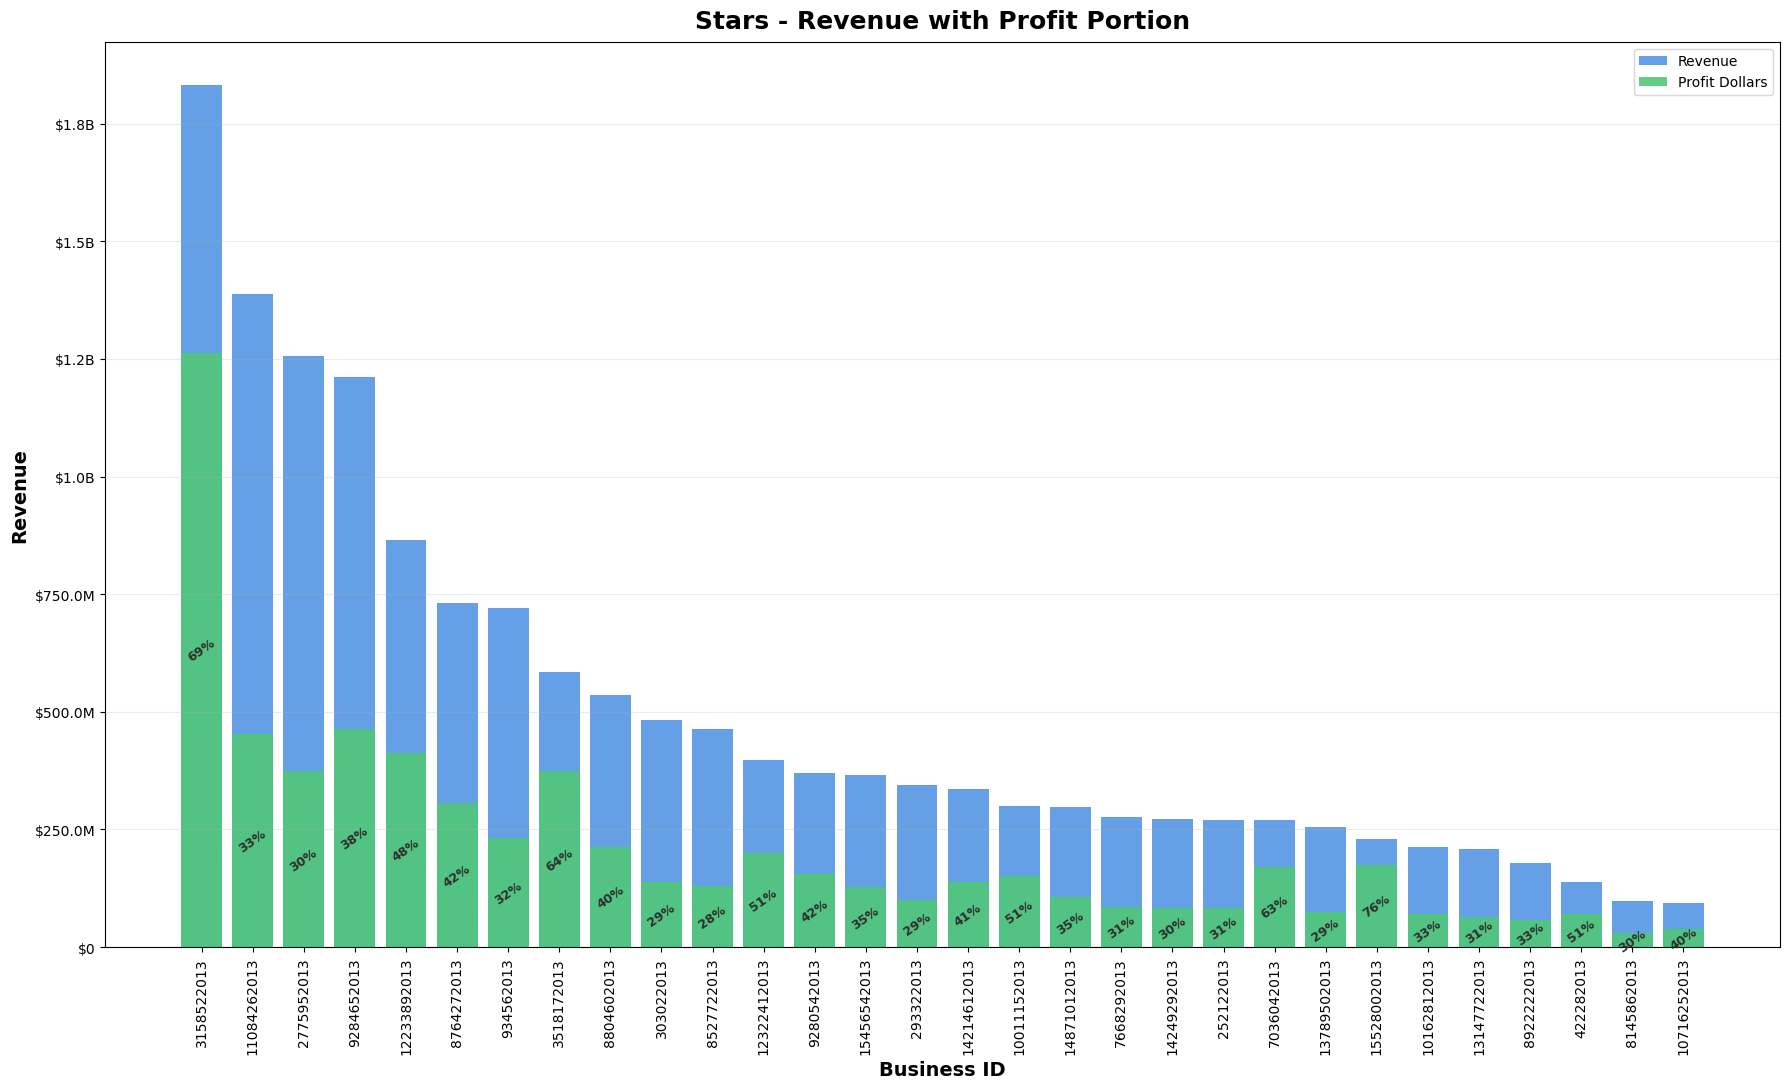

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Patch

def fmt_money(v):
    if v >= 1_000_000_000: return f"${v/1_000_000_000:.1f}B"
    if v >= 1_000_000:     return f"${v/1_000_000:.1f}M"
    if v >= 1_000:         return f"${v/1_000:.0f}K"
    return f"${v:.0f}"

def ensure_segments(df):
    # Adds df['Segment'] if it doesn't exist, using medians of PM & Revenue
    if "Segment" in df.columns:
        return df
    pm_med  = float(df["Profit Margin"].median())
    rev_med = float(df["Total Revenue"].median())
    pm_high  = df["Profit Margin"] >= pm_med
    rev_high = df["Total Revenue"] >= rev_med
    seg = np.where(rev_high & pm_high, "STARS",
          np.where(rev_high & ~pm_high, "VOLUME PLAYERS",
          np.where(~rev_high & pm_high, "NICHE WINNERS", "STRUGGLERS")))
    df = df.copy()
    df["Segment"] = seg
    return df

def plot_stars_revenue_with_profit(df, top_n=None, title="Stars - Revenue with Profit Portion"):
    df = ensure_segments(df)
    stars = df[df["Segment"] == "STARS"].copy()
    if stars.empty:
        raise ValueError("No rows labeled STARS. Make sure medians/segments are computed.")
    
    # compute profit dollars
    stars["Profit_Dollars"] = stars["Total Revenue"] * stars["Profit Margin"]
    # sort by revenue
    stars = stars.sort_values("Total Revenue", ascending=False)
    if top_n is not None:
        stars = stars.head(int(top_n))
    
    xlabels = stars["Business ID"].astype(str).tolist()
    rev     = stars["Total Revenue"].to_numpy(float)
    prof    = stars["Profit_Dollars"].to_numpy(float)
    pm      = stars["Profit Margin"].to_numpy(float)  # 0.35 = 35%

    # colors
    c_revenue = "#4A90E2"  # blue
    c_profit  = "#50C878"  # emerald green

    fig, ax = plt.subplots(figsize=(max(16, 0.4*len(xlabels)+6), 11))

    # full revenue bars
    ax.bar(range(len(xlabels)), rev, color=c_revenue, alpha=0.85, label="Revenue")

    # profit overlay (narrower width so it reads like an inner fill)
    ax.bar(range(len(xlabels)), prof, width=0.8, color=c_profit, alpha=0.9, label="Profit Dollars")

    # centered PM% label inside the profit overlay
    for i, (p, r, m) in enumerate(zip(prof, rev, pm)):
        if p > 0:
            ax.text(i, p/2, f"{m:.0%}", ha="center", va="center",
                    fontsize=9, color="#2E2E2E", fontweight="bold", rotation=35)
        else:
            # edge case: tiny profit -> put label near top of revenue bar
            ax.text(i, max(r*0.05, 1.0), f"{m:.0%}", ha="center", va="bottom",
                    fontsize=9, color="black")

    # axes, ticks, grid
    ax.set_ylabel("Revenue", fontsize=14, fontweight="bold")
    ax.set_xlabel("Business ID", fontsize=14, fontweight="bold")
    ax.set_title(title, fontsize=18, fontweight="bold", pad=10)
    ax.set_xticks(range(len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=90)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: fmt_money(v)))
    ax.grid(axis="y", alpha=0.25)

    # legend with distinct colors
    legend_patches = [
        Patch(facecolor=c_revenue, alpha=0.85, label="Revenue"),
        Patch(facecolor=c_profit,  alpha=0.9,  label="Profit Dollars"),
    ]
    ax.legend(handles=legend_patches, loc="upper right")

    plt.tight_layout()
    return fig, ax

plot_stars_revenue_with_profit(df, top_n=30)
plt.show()